In [14]:
pip install statsmodels scikit_posthocs scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

#plt.style.use('seaborn-darkgrid')
sns.set_context('notebook')

## Reading tables 

In [16]:
# Reading CSV files
label_table = pd.read_csv("../../data/label_dataset.csv", usecols=lambda column: column != 'Unnamed: 0')
print(label_table.dtypes)

releases_with_git_url = pd.read_csv("releases_with_git_url.csv", usecols=lambda column: column != 'Unnamed: 0')
print(releases_with_git_url.dtypes)

# Joining dataframes
releases_label = pd.merge(releases_with_git_url, label_table, on="repo_id", how="inner")
print(releases_label.dtypes)
print()

# Selecting specific columns
releasesSelectedVar = releases_label[['repo_id', 'releases', 'label_name']]

repo_id        int64
label_name    object
dtype: object


rg_name          object
repo_group_id     int64
repo_name        object
repo_id           int64
repo_git         object
forked_from      object
repo_archived     int64
releases          int64
dtype: object
rg_name          object
repo_group_id     int64
repo_name        object
repo_id           int64
repo_git         object
forked_from      object
repo_archived     int64
releases          int64
label_name       object
dtype: object



### removing outliers

In [17]:
# Exclude outliers
def exclude_outliers(data, variable, group_var, sd_threshold=2):
    # Function to filter outliers in a group
    def filter_group(group):
        mean_val = group[variable].mean()
        sd_val = group[variable].std()
        return group[np.abs(group[variable] - mean_val) < sd_threshold * sd_val]
    
    # Apply the filter function to each group and combine the results
    return data.groupby(group_var).apply(filter_group).reset_index(drop=True)

In [18]:
releasesSelectedVar_filtered = exclude_outliers(releasesSelectedVar, "releases", "label_name", sd_threshold=2)

/var/folders/xy/1s8thl_55ln_cdl_bngsdtzr0000gn/T/ipykernel_19681/1596213973.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(group_var).apply(filter_group).reset_index(drop=True)


## calculating stats to show on plot

In [19]:
# Calculate stats to show on the plot
stats_df = releasesSelectedVar_filtered.groupby('label_name')['releases'].agg(
    average='mean',
    upper_quartile=lambda x: x.quantile(0.75)
).reset_index()

stats_df['label_pos'] = stats_df['upper_quartile'] + 0.5

## generating boxplot

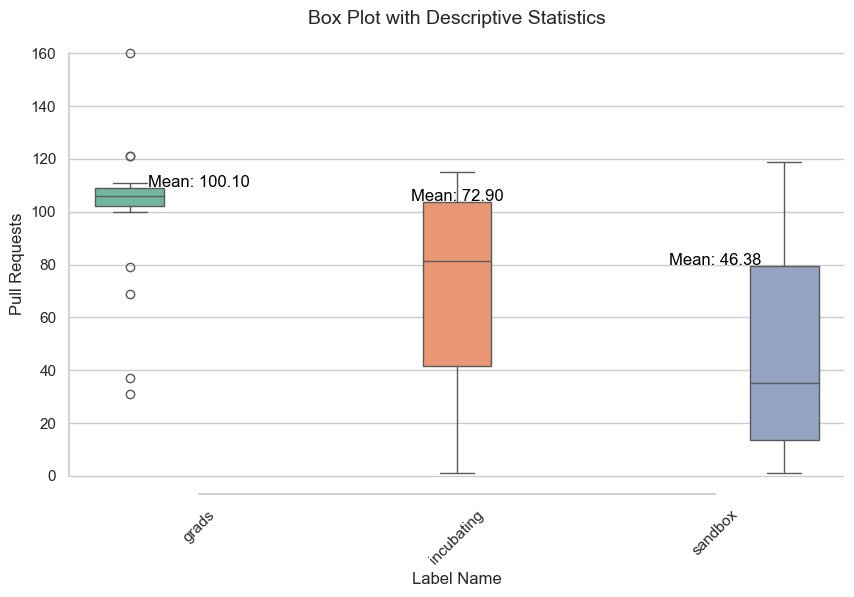

In [20]:
# Set plots style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot
ax = sns.boxplot(x='label_name', y='releases', data=releasesSelectedVar_filtered, palette="Set2", dodge=True, hue="label_name")

# Add mean values as text on the plot
for index, row in stats_df.iterrows():
    ax.text(
        x=index, 
        y=row['label_pos'], 
        s=f"Mean: {row['average']:.2f}", 
        color='black', 
        ha="center", 
        size=12
    )

# Set plot title and labels
ax.set_title('Box Plot with Descriptive Statistics', fontsize=14)
ax.set_xlabel('Label Name', fontsize=12)
ax.set_ylabel('Pull Requests', fontsize=12)

# Making plot easier to read
sns.despine(trim=True)
plt.xticks(rotation=45)

plt.show()

# testing normality and variance homogeneity 

## 1) Distribuation visualizations - Density plot

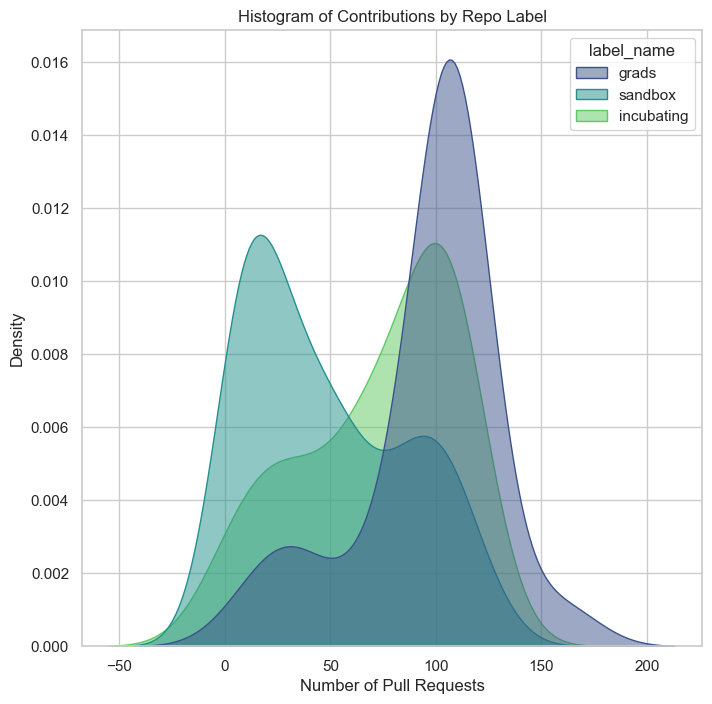

In [21]:
# Create a density plot
plt.figure(figsize=(8, 8))
#sns.kdeplot(data=commitSelectedVar, x='commits', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='coolwarm')
sns.kdeplot(data=releasesSelectedVar, x='releases', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='viridis')

plt.title('Histogram of Contributions by Repo Label')
plt.xlabel('Number of Pull Requests')
plt.ylabel('Density')
plt.show()

## Kruskal-Wallis H test to test whether there is a significant difference among pairs of groups

In [22]:
# Preparing data for Kruskal-Wallis H Test
# Do the differences in commits between groups mean ANYTHING? Or is this not a potential feature?
groups = [group['releases'].values for name, group in releasesSelectedVar.groupby('label_name')]

# Perform Kruskal-Wallis H Test
stat, p = kruskal(*groups)
print(f'Kruskal-Wallis H Test Statistic: {stat}, P-value: {p}')


Kruskal-Wallis H Test Statistic: 30.610159608512717, P-value: 2.2546975655828538e-07


## Dunn's test to conduct post-hoc test for examining the differience between each pair of groups.

In [23]:
# Conduct Dunn's Test
dunn_test_result = sp.posthoc_dunn(releasesSelectedVar, val_col='releases', group_col='label_name', p_adjust='fdr_bh')

print(dunn_test_result)

                   grads  incubating       sandbox
grads       1.000000e+00    0.034524  7.568086e-07
incubating  3.452385e-02    1.000000  4.438452e-03
sandbox     7.568086e-07    0.004438  1.000000e+00
